In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ==============================================================================
# 1. 环境与路径设置
# ==============================================================================
# 设置结果保存路径
RESULT_DIR = 'Result'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# 设置全局绘图风格，遵循您的个性化要求
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
print("--- [环境设置] 全局绘图风格已配置 ---")


# ==============================================================================
# 2. 数据加载
# ==============================================================================
# 注意：请确保数据文件已放置在正确的相对路径下
try:
    file_path = '../../Data/0/女胎_预处理后数据.csv'
    female_data = pd.read_csv(file_path)
    print(f"--- [数据加载] 成功加载数据，维度: {female_data.shape} ---")
except FileNotFoundError:
    print(f"!!! 错误: 未在指定路径找到文件 '{file_path}'")
    print("!!! 请将 '女胎_预处理后数据.csv' 文件放置在正确目录下后再继续。")
    # 如果文件不存在，后续将无法进行，此处仅为提示
    female_data = None

# ==============================================================================
# 3. 初步探查 (确认不平衡比例)
# ==============================================================================
if female_data is not None:
    # 填充 '染色体的非整倍体' 列的缺失值，便于统计
    # 空白即为无异常，我们用 '正常' 文本填充
    target_col = '染色体的非整倍体'
    female_data[target_col] = female_data[target_col].fillna('正常')
    
    # 统计各类别的数量
    class_counts = female_data[target_col].value_counts()
    print("\n--- [数据探查] 原始数据类别分布 ---")
    print(class_counts)
    
    # 计算异常与正常的比例
    normal_count = class_counts.get('正常', 0)
    abnormal_count = female_data.shape[0] - normal_count
    
    if abnormal_count > 0:
        ratio = normal_count / abnormal_count
        print(f"正常样本数: {normal_count}, 异常样本数: {abnormal_count}")
        print(f"比例 (正常:异常) ≈ {ratio:.2f} : 1")
    else:
        print("数据集中未发现异常样本。")

--- [环境设置] 全局绘图风格已配置 ---
--- [数据加载] 成功加载数据，维度: (529, 39) ---

--- [数据探查] 原始数据类别分布 ---
染色体的非整倍体
正常        466
T18        32
T13        10
T21         9
T13T18      9
T18T21      2
T13T21      1
Name: count, dtype: int64
正常样本数: 466, 异常样本数: 63
比例 (正常:异常) ≈ 7.40 : 1


In [44]:
from sklearn.model_selection import train_test_split

# 确保上一步的数据已成功加载
if 'female_data' in locals() and female_data is not None:
    # ==============================================================================
    # 1. 定义特征 (X) 与目标 (y)
    # ==============================================================================
    # 方案中确定的输入特征
    features = [
        '孕妇年龄', '孕妇BMI', '孕周',
        '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值',
        '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', 'GC含量',
        '原始测序数据的总读段数(个)', '总读段数中在参考基因组上比对的比例',
        '总读段数中重复读段的比例', '总读段数中唯一比对的读段数(个)',
        '被过滤掉的读段数占总读段数的比例'
    ]
    # 确保所有特征列都存在于DataFrame中
    features = [f for f in features if f in female_data.columns]
    
    X = female_data[features]
    
    # 创建二分类目标变量 `is_abnormal` (0: 正常, 1: 异常)
    y = female_data['染色体的非整倍体'].apply(lambda x: 0 if x == '正常' else 1)
    
    print("--- [特征工程] 特征集 (X) 和目标集 (y) 构建完成 ---")
    print(f"使用的特征数量: {len(features)}")
    print("目标变量 'is_abnormal' 分布:")
    print(y.value_counts())
    
    # ==============================================================================
    # 2. 划分训练集与测试集
    # ==============================================================================
    # 严格分层抽样，确保训练集和测试集中的类别比例一致
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,       # 30% 作为测试集
        random_state=42,     # 保证结果可复现
        stratify=y           # !!! 核心：必须分层
    )
    
    print("\n--- [数据划分] 训练集与测试集划分完成 ---")
    print(f"训练集维度: {X_train.shape}")
    print(f"测试集维度: {X_test.shape}")
    print(f"训练集异常样本比例: {y_train.mean():.4f}")
    print(f"测试集异常样本比例: {y_test.mean():.4f}")

else:
    print("!!! 错误: female_data 未定义，请先成功运行第一步代码。")

--- [特征工程] 特征集 (X) 和目标集 (y) 构建完成 ---
使用的特征数量: 10
目标变量 'is_abnormal' 分布:
染色体的非整倍体
0    466
1     63
Name: count, dtype: int64

--- [数据划分] 训练集与测试集划分完成 ---
训练集维度: (370, 10)
测试集维度: (159, 10)
训练集异常样本比例: 0.1189
测试集异常样本比例: 0.1195


In [45]:
# ==============================================================================
# 第三步：SMOTE过采样 (1:2 平衡版)
# ==============================================================================
# 需要安装 imbalanced-learn: pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

# 确保上一步的数据已成功划分
if 'X_train' in locals():
    # ==============================================================================
    # 1. 应用 SMOTE
    # ==============================================================================
    print("\n--- [SMOTE处理] 开始对训练集进行过采样 (目标比例 1:2) ---")
    print(f"原始训练集样本分布: {sorted(Counter(y_train).items())}")
    
    # sampling_strategy 设置为 0.5 来实现 1:2 的比例
    smote = SMOTE(
        sampling_strategy=0.5,  # <-- 核心改动：使少数类样本数达到多数类的一半
        random_state=42
    )
    
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # 验证采样后的比例
    counts = Counter(y_train_smote)
    ratio = counts[1] / counts[0] if counts[0] != 0 else 0
    print(f"SMOTE后训练集样本分布: {sorted(counts.items())}")
    print(f"SMOTE后训练集维度: {X_train_smote.shape}")
    print(f"验证比例 (异常/正常): {ratio:.4f}")
    print("--- [SMOTE处理] 处理完成，测试集保持不变 ---")

else:
    print("!!! 错误: 训练集未定义，请先成功运行第二步代码。")


--- [SMOTE处理] 开始对训练集进行过采样 (目标比例 1:2) ---
原始训练集样本分布: [(0, 326), (1, 44)]
SMOTE后训练集样本分布: [(0, 326), (1, 163)]
SMOTE后训练集维度: (489, 10)
验证比例 (异常/正常): 0.5000
--- [SMOTE处理] 处理完成，测试集保持不变 ---


In [46]:
# ==============================================================================
# 第四步：多模型训练与优化 (逻辑回归使用GridSearchCV)
# ==============================================================================
from sklearn.model_selection import GridSearchCV # <-- 引入GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 确保上一步的SMOTE数据已生成
if 'X_train_smote' in locals():
    # 存储训练好的模型
    models = {}

    # ==============================================================================
    # 1. 新增：使用GridSearchCV优化并训练逻辑回归
    # ==============================================================================
    print("\n--- [模型训练] 开始使用GridSearchCV优化逻辑回归 ---")
    
    # 定义逻辑回归的参数网格
    # C: 正则化强度的倒数，值越小正则化越强
    # penalty: 正则化类型
    # solver: 不同的求解器支持不同的正则化类型
    param_grid_lr = [
        {
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear'] # liblinear求解器同时支持L1和L2
        }
    ]
    
    # 设置GridSearchCV
    grid_search_lr = GridSearchCV(
        estimator=LogisticRegression(random_state=42, max_iter=1000),
        param_grid=param_grid_lr,
        cv=5,                 # 5折交叉验证
        scoring='roc_auc',    # 使用AUC作为评估指标
        n_jobs=-1,
        verbose=1
    )
    
    # 在SMOTE处理后的训练集上执行搜索
    grid_search_lr.fit(X_train_smote, y_train_smote)
    
    # 获取最优模型并存入字典
    best_lr = grid_search_lr.best_estimator_
    models['Optimized LR'] = best_lr
    
    print("逻辑回归GridSearchCV优化完成。")
    print("最佳参数:", grid_search_lr.best_params_)
    print("最佳AUC得分 (交叉验证):", grid_search_lr.best_score_)


    # ==============================================================================
    # 2. 训练其他模型 (此部分不变)
    # ==============================================================================
    print("\n--- [模型训练] 开始训练其他基准模型 ---")
    
    # 决策树
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train_smote, y_train_smote)
    models['Decision Tree'] = dt
    print("决策树模型训练完成。")
    
    # 随机森林
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train_smote, y_train_smote)
    models['Random Forest'] = rf
    print("随机森林模型训练完成。")
    
    # XGBoost (带随机搜索优化)
    print("\n--- [模型训练] 开始使用随机搜索优化训练XGBoost ---")
    param_dist_xgb = {
        'learning_rate': uniform(0.01, 0.3), 'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10), 'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4), 'gamma': uniform(0, 1),
        'reg_alpha': uniform(0, 1), 'reg_lambda': uniform(1, 4)
    }
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
    random_search_xgb = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist_xgb, n_iter=50, cv=5, n_jobs=-1, scoring='roc_auc', random_state=42, verbose=1)
    random_search_xgb.fit(X_train_smote, y_train_smote)
    best_xgb = random_search_xgb.best_estimator_
    models['Optimized XGBoost'] = best_xgb
    print("XGBoost随机搜索优化完成。")
    print("最佳参数:", random_search_xgb.best_params_)
    print("最佳AUC得分 (交叉验证):", random_search_xgb.best_score_)

else:
    print("!!! 错误: SMOTE处理后的训练集未定义，请先成功运行第三步代码。")


--- [模型训练] 开始使用GridSearchCV优化逻辑回归 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
逻辑回归GridSearchCV优化完成。
最佳参数: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
最佳AUC得分 (交叉验证): 0.8225393356643357

--- [模型训练] 开始训练其他基准模型 ---
决策树模型训练完成。
随机森林模型训练完成。

--- [模型训练] 开始使用随机搜索优化训练XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


d:\Conda\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:37:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost随机搜索优化完成。
最佳参数: {'colsample_bytree': np.float64(0.9074216057225236), 'gamma': np.float64(0.04360377175443375), 'learning_rate': np.float64(0.3083651532392023), 'max_depth': 8, 'n_estimators': 576, 'reg_alpha': np.float64(0.2795603417967586), 'reg_lambda': np.float64(4.533976089065035), 'subsample': np.float64(0.8990875095589655)}
最佳AUC得分 (交叉验证): 0.9345993589743589



--- [模型评估] 开始在原始测试集上评估所有模型 ---

===== 评估模型: Optimized LR =====
分类报告:
              precision    recall  f1-score   support

          正常       0.94      0.89      0.92       140
          异常       0.42      0.58      0.49        19

    accuracy                           0.86       159
   macro avg       0.68      0.74      0.70       159
weighted avg       0.88      0.86      0.86       159

混淆矩阵已保存至: Result\图_Optimized LR_混淆矩阵.png

===== 评估模型: Decision Tree =====
分类报告:
              precision    recall  f1-score   support

          正常       0.89      0.84      0.86       140
          异常       0.18      0.26      0.21        19

    accuracy                           0.77       159
   macro avg       0.54      0.55      0.54       159
weighted avg       0.81      0.77      0.79       159

混淆矩阵已保存至: Result\图_Decision Tree_混淆矩阵.png

===== 评估模型: Random Forest =====
分类报告:
              precision    recall  f1-score   support

          正常       0.89      0.96      0.92       140
      

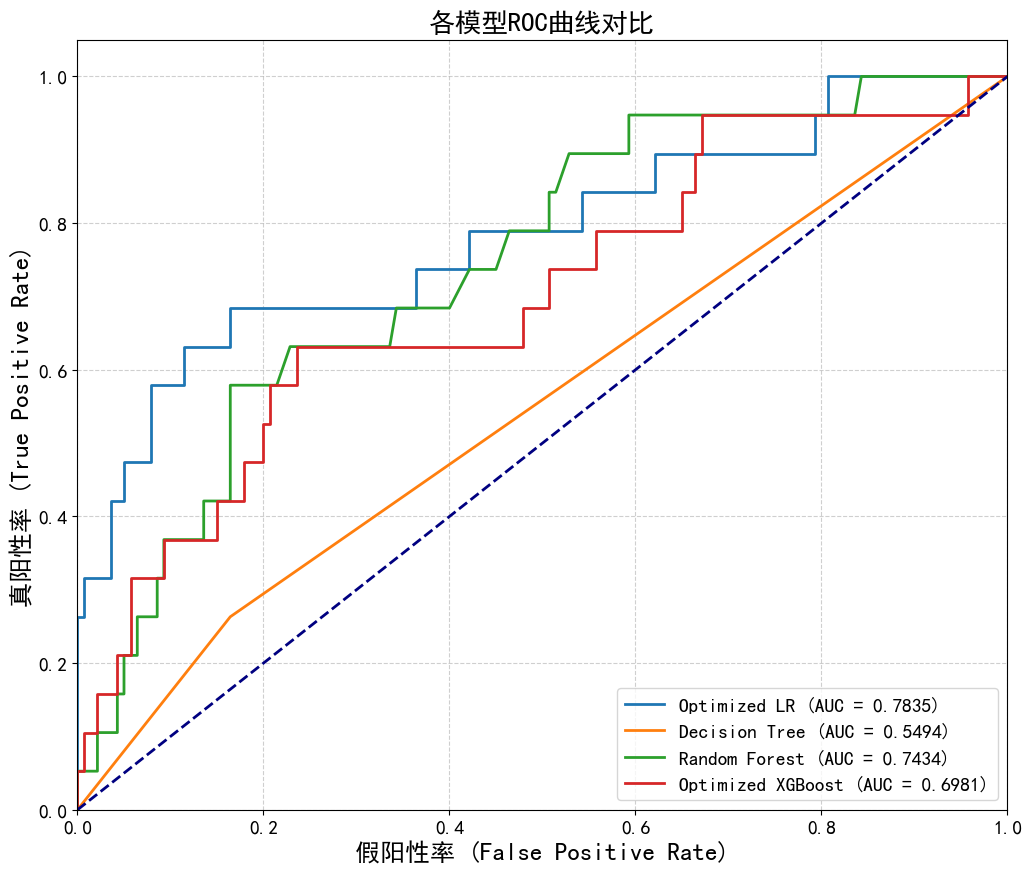

In [47]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)

# 确保模型已训练完成
if 'models' in locals() and models:
    print("\n--- [模型评估] 开始在原始测试集上评估所有模型 ---")
    
    # 准备绘制ROC曲线
    fig_roc, ax_roc = plt.subplots(figsize=(12, 10))
    
    for name, model in models.items():
        print(f"\n===== 评估模型: {name} =====")
        
        # 1. 预测
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # 2. 生成分类报告
        report = classification_report(y_test, y_pred, target_names=['正常', '异常'])
        print("分类报告:")
        print(report)
        
        # 3. 绘制混淆矩阵
        fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['正常', '异常'])
        disp.plot(cmap='Blues', ax=ax_cm)
        ax_cm.set_title(f'{name} 混淆矩阵')
        
        # 保存混淆矩阵图像
        cm_path = os.path.join(RESULT_DIR, f'图_{name}_混淆矩阵.png')
        fig_cm.savefig(cm_path, dpi=300, bbox_inches='tight')
        print(f"混淆矩阵已保存至: {cm_path}")
        plt.close(fig_cm) # 关闭图像，避免过多显示
        
        # 4. 计算并绘制ROC曲线
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

    # 美化ROC曲线图
    ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('假阳性率 (False Positive Rate)')
    ax_roc.set_ylabel('真阳性率 (True Positive Rate)')
    ax_roc.set_title('各模型ROC曲线对比')
    ax_roc.legend(loc="lower right", fontsize=14)
    ax_roc.grid(True, linestyle='--', alpha=0.6)
    
    # 保存ROC曲线图像
    roc_path = os.path.join(RESULT_DIR, '图_ROC曲线对比.png')
    fig_roc.savefig(roc_path, dpi=300, bbox_inches='tight')
    print(f"\nROC曲线对比图已保存至: {roc_path}")
    plt.show()

else:
    print("!!! 错误: 模型未训练，请先成功运行第四步代码。")


--- [模型解释] 开始为模型 'Optimized LR' 生成SHAP分析图 ---
SHAP值计算完成。
SHAP全局特征重要性图已保存至: Result\图_SHAP_LR_全局特征重要性.png
SHAP摘要图已保存至: Result\图_SHAP_LR_摘要图.png


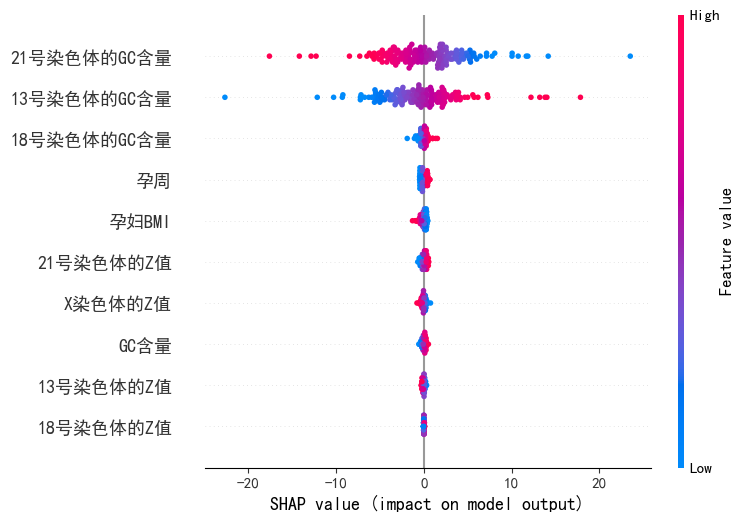

In [49]:
# ==============================================================================
# 第六步：最终模型解释 (SHAP for Logistic Regression)
# ==============================================================================
# 需要安装 shap: pip install shap
import shap

# 确定要解释的模型为我们优化后的逻辑回归
model_to_explain_name = 'Optimized LR'

if 'models' in locals() and model_to_explain_name in models:
    lr_model = models[model_to_explain_name]
    
    print(f"\n--- [模型解释] 开始为模型 '{model_to_explain_name}' 生成SHAP分析图 ---")
    
    # ==============================================================================
    # 1. 创建SHAP解释器并计算SHAP值
    # ==============================================================================
    # 对于逻辑回归等线性模型，SHAP会使用高效的LinearExplainer。
    # 我们使用通用的 shap.Explainer API，它会自动选择最合适的解释器。
    # 注意：线性解释器需要一个“背景”数据集来计算期望值，通常使用训练数据。
    explainer = shap.Explainer(lr_model, X_train_smote)
    
    # 在测试集上计算SHAP值
    shap_values = explainer(X_test)
    
    print("SHAP值计算完成。")
    
    # ==============================================================================
    # 2. 绘制SHAP全局特征重要性图 (Bar Plot)
    # ==============================================================================
    # 对于SHAP，全局重要性是所有样本SHAP值的绝对值的平均值
    fig_bar, ax_bar = plt.subplots()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    
    # 自定义美化
    ax_bar = plt.gca() # 获取当前坐标轴
    ax_bar.set_xlabel("平均SHAP绝对值 (特征对预测的平均影响幅度)", fontsize=16)
    ax_bar.tick_params(axis='y', labelsize=14)
    
    # 保存图像
    bar_path = os.path.join(RESULT_DIR, '图_SHAP_LR_全局特征重要性.png')
    fig_bar.savefig(bar_path, dpi=300, bbox_inches='tight')
    print(f"SHAP全局特征重要性图已保存至: {bar_path}")
    plt.close(fig_bar)
    
    # ==============================================================================
    # 3. 绘制SHAP摘要图 (Summary Plot / Beeswarm Plot)
    # ==============================================================================
    fig_summary, ax_summary = plt.subplots()
    shap.summary_plot(shap_values, X_test, show=False)
    
    # 保存图像
    summary_path = os.path.join(RESULT_DIR, '图_SHAP_LR_摘要图.png')
    fig_summary.savefig(summary_path, dpi=300, bbox_inches='tight')
    print(f"SHAP摘要图已保存至: {summary_path}")
    plt.show()

else:
    print(f"!!! 错误: 找不到名为 '{model_to_explain_name}' 的模型，请先成功运行第四、五步代码。")